# Ejercicio práctico de un modelo supervisado de clasificación

El objetivo de este notebook, dado el dataset **Wine**, es desarrollar un modelo de clasificación supervisado para comprobar si somos capaces de entrenar un modelo que prediga los **3 tipos distintos de vino** presentes en los datos explorados.

El desarrollo del notebook se compone de **4 pasos fundamentales**:

- La carga, preparación y realización del *Exploratory Data Analysis (EDA)* de los datos.  
- El procesado e ingeniería de características de dichos datos.  
- El entrenamiento del modelo de clasificación.  
- La validación de los resultados obtenidos y la conclusión final del desarrollo.  

---

**Autor:** *Eduardo Ballesteros Pérez*


# 0 - Instalaciones necesarias e importación de librerías utilizadas

## Instalación de librerías

Además de la librería propia del dataset objeto de estudio, se ha instalado la librería de **XGBoost**, al ser el modelo empleado para el desarrollo (la elección de este modelo se justificará más adelante en este notebook), y la librería **scikit-plot**, utilizada para la evaluación del modelo.

Si durante la fase de importación el usuario se encuentra con algún error, deberá añadir la instalación de la librería correspondiente en este bloque.


In [53]:
%%capture
!pip install ucimlrepo

In [54]:
%%capture
!pip install xgboost

In [55]:
%%capture
!pip install scikit-plot

## Importación de librerias

En este bloque se cargan las librerías necesarias para trabajar con datos, entrenar el modelo y evaluarlo.

### Librerías principales
- **pandas**, **numpy**: para manejar y procesar datos.
- **matplotlib.pyplot**: para crear gráficos.
- **xgboost**: para utilizar el modelo de clasificación XGBoost.

### Funciones de Scikit-Learn
- `train_test_split`: divide los datos en entrenamiento y test.
- `accuracy_score`, `precision_score`, `recall_score`, `roc_auc_score`: métricas para evaluar el modelo.
- `confusion_matrix`, `ConfusionMatrixDisplay`: para generar y visualizar la matriz de confusión.

### Otras utilidades
- **random**: para fijar semillas y hacer el experimento reproducible.
- `fetch_ucirepo`: para cargar el dataset *Wine* desde el repositorio UCI.



In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import random

from ucimlrepo import fetch_ucirepo

In [57]:
pd.options.display.max_columns = 100

# 1 - Carga, preparación y EDA de los datos

## 1.1 - Carga del dataset

La carga del dataset se realiza utilizando la librería desarrollada por la Universidad Pública de Irvine.

In [58]:
# Descargamos el dataset Wine desde el repositorio UCI (id=109).
# 'features' contiene las variables independientes (X) y 'targets' contiene la variable objetivo (y).
# Se guardan como DataFrames para su posterior análisis y modelado.

wine = fetch_ucirepo(id=109)

df_train_raw = wine.data.features 
df_target_raw = wine.data.targets 


In [59]:
# df_train_raw contiene todas las características del vino (las variables X),
# es decir, los datos de entrada que usará el modelo para aprender,
# sin incluir la columna del target.
df_train_raw

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [60]:
# Mostramos las filas del target para comprobar su estructura
df_target_raw

,class
0,1
1,1
2,1
3,1
4,1
...,...
173,3
174,3
175,3
176,3


In [61]:
# Consultamos la forma del dataset: número de filas y columnas de df_train_raw
df_train_raw.shape

(178, 13)

## 1.2 - Preparación del dataset

En este punto, se unen los datos y las etiquetas (descargados por separado durante la carga del dataset).

In [62]:
# Imprimimos por pantalla cómo es la variable objetivo inicialmente.
df_target_raw.value_counts()

class
2        71
1        59
3        48
Name: count, dtype: int64

In [63]:
# Añadimos al dataframe la etiqueta (target) correspondiente a cada vino.
df_train_raw['target'] = df_target_raw['class']


df_train_raw['target'].value_counts()

target
2    71
1    59
3    48
Name: count, dtype: int64

## 1.3 – EDA

En este punto, se realiza el EDA del dataset propuesto. A diferencia del análisis no supervisado, en este desarrollo sí contamos con la **variable objetivo (target)**, lo que nos permitirá explorar no solo las características numéricas, sino también su relación con la clase del vino.

El análisis se divide en dos apartados:

- Una exploración preliminar de las variables numéricas.
- Una exploración gráfica tanto de las variables como de su relación con el target.

Como punto previo, recordamos que las variables incluidas en este dataset son las siguientes (todas ellas numéricas):

- **Alcohol**: porcentaje de alcohol del vino.  
- **Malicacid**: concentración de ácido málico.  
- **Ash**: cantidad de cenizas en el vino después de quemarlo.  
- **Alcalinity_of_ash**: alcalinidad de las cenizas.  
- **Magnesium**: contenido de magnesio (partes por millón).  
- **Total_phenols**: concentración total de compuestos fenólicos.  
- **Flavanoids**: subgrupo de fenoles asociados a sabor y antioxidantes.  
- **Nonflavanoid_phenols**: fenoles no flavonoides.  
- **Proanthocyanins**: tipo de tanino presente en el vino.  
- **Color_intensity**: intensidad del color del vino.  
- **Hue**: tono del color del vino (matiz).  
- **OD280_OD315_of_diluted_wines**: relación entre absorbancia y calidad.  
- **Proline**: cantidad de prolina (aminoácido relacionado con sabor y aroma).  

Además, en el contexto del aprendizaje supervisado, incluimos también:

- **target**: variable objetivo que indica la clase del vino (1, 2 o 3).

---

### 1.3.1 – Exploración preliminar de las variables numéricas

En este apartado comenzamos analizando métricas básicas (media, desviación, mínimos y máximos) para obtener una vista general de la distribución de las variables.  
Adicionalmente, examinamos la matriz de correlación para identificar relaciones relevantes entre las características y su posible utilidad para el modelo de clasificación.


In [64]:
# Obtenemos un resumen estadístico de las variables numéricas del dataset 
df_train_raw.describe().round(2)

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,target
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,13.00,2.34,2.37,19.49,99.74,2.30,2.03,0.36,1.59,5.06,0.96,2.61,746.89,1.94
std,0.81,1.12,0.27,3.34,14.28,0.63,1.00,0.12,0.57,2.32,0.23,0.71,314.91,0.78
min,11.03,0.74,1.36,10.60,70.00,0.98,0.34,0.13,0.41,1.28,0.48,1.27,278.00,1.00
25%,12.36,1.60,2.21,17.20,88.00,1.74,1.20,0.27,1.25,3.22,0.78,1.94,500.50,1.00
50%,13.05,1.87,2.36,19.50,98.00,2.36,2.13,0.34,1.56,4.69,0.96,2.78,673.50,2.00
75%,13.68,3.08,2.56,21.50,107.00,2.80,2.88,0.44,1.95,6.20,1.12,3.17,985.00,3.00
max,14.83,5.80,3.23,30.00,162.00,3.88,5.08,0.66,3.58,13.00,1.71,4.00,1680.00,3.00


In [65]:
# Calculamos la matriz de correlación para analizar qué variables numéricas 
# están más relacionadas entre sí.
df_train_raw.corr(numeric_only = True).round(2)

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,target
Alcohol,1.00,0.09,0.21,-0.31,0.27,0.29,0.24,-0.16,0.14,0.55,-0.07,0.07,0.64,-0.33
Malicacid,0.09,1.00,0.16,0.29,-0.05,-0.34,-0.41,0.29,-0.22,0.25,-0.56,-0.37,-0.19,0.44
Ash,0.21,0.16,1.00,0.44,0.29,0.13,0.12,0.19,0.01,0.26,-0.07,0.00,0.22,-0.05
Alcalinity_of_ash,-0.31,0.29,0.44,1.00,-0.08,-0.32,-0.35,0.36,-0.20,0.02,-0.27,-0.28,-0.44,0.52
Magnesium,0.27,-0.05,0.29,-0.08,1.00,0.21,0.20,-0.26,0.24,0.20,0.06,0.07,0.39,-0.21
Total_phenols,0.29,-0.34,0.13,-0.32,0.21,1.00,0.86,-0.45,0.61,-0.06,0.43,0.70,0.50,-0.72
Flavanoids,0.24,-0.41,0.12,-0.35,0.20,0.86,1.00,-0.54,0.65,-0.17,0.54,0.79,0.49,-0.85
Nonflavanoid_phenols,-0.16,0.29,0.19,0.36,-0.26,-0.45,-0.54,1.00,-0.37,0.14,-0.26,-0.50,-0.31,0.49
Proanthocyanins,0.14,-0.22,0.01,-0.20,0.24,0.61,0.65,-0.37,1.00,-0.03,0.30,0.52,0.33,-0.50
Color_intensity,0.55,0.25,0.26,0.02,0.20,-0.06,-0.17,0.14,-0.03,1.00,-0.52,-0.43,0.32,0.27


### Primera lectura del análisis descriptivo y la matriz de correlación

A partir del resumen estadístico y de la matriz de correlación pueden extraerse algunas conclusiones rápidas:

1. **Variabilidad de los datos**  
   Variables como **Proline**, **Color_intensity** y **Malicacid** muestran gran variación entre vinos, mientras que otras como **Alcohol** o **Ash** son más estables.

2. **Relaciones entre variables**  
   Características como **Total_phenols**, **Flavanoids** y **OD280_OD315** están muy correlacionadas entre sí, indicando que describen un comportamiento químico similar.

3. **Relación con el target**  
   Las variables más útiles para distinguir entre clases son **Flavanoids**, **OD280_OD315**, **Total_phenols**, **Proline** y **Hue**, todas con correlaciones fuertes con la variable objetivo.

4. **Conclusión general**  
   El dataset muestra buena variabilidad y relaciones claras entre variables, lo cual facilita el desarrollo de un modelo supervisado de clasificación.


### 1.3.2 – Exploración gráfica de las variables numéricas

Para este punto, y por comodidad, se ha desarrollado la función `plot_num_feat`.  
Esta función permite visualizar, para las agrupaciones de la característica numérica seleccionada por el usuario, la distribución de cada una de las clases del target mediante un diagrama de barras.

Además, sobre el mismo gráfico se incluye una línea que muestra el porcentaje acumulado de cada categoría respecto al total.  
Opcionalmente, también se puede mostrar un boxplot de la característica numérica para ayudar en el análisis visual.

El código de la función se encuentra comentado para facilitar su comprensión.


In [66]:
def plot_num_feat(df, feat, bins, print_box=False):
    """
    Función para analizar gráficamente una variable numérica en relación con el target.
    Permite ver cómo se distribuyen las clases dentro de diferentes rangos (bins) de la variable
    y qué porcentaje total del dataset cae en cada rango.

    Parámetros:
      - df: DataFrame que contiene los datos y el target.
      - feat: nombre de la característica numérica a analizar.
      - bins: número de particiones deseado o lista de puntos de corte para generar los grupos.
      - print_box: si se activa, muestra un diagrama de caja (boxplot) de la característica.
    """

    # ---------------------------------------------------------------
    # 1) Creamos un DataFrame auxiliar solo con la variable y el target
    # ---------------------------------------------------------------
    df_binned = df[[feat, 'target']].copy()

    # ---------------------------------------------------------------
    # 2) Generamos los intervalos (bins) para la variable numérica
    #    pd.cut divide la columna 'feat' según el número de bins o cortes que pasemos.
    # ---------------------------------------------------------------
    df_binned['bins'] = pd.cut(df[feat], bins=bins)

    # ---------------------------------------------------------------
    # 3) Calculamos el % de cada clase dentro de cada grupo (bin)
    #    value_counts(normalize=True) → da proporciones en lugar de conteos
    #    unstack() → convierte las clases en columnas
    # ---------------------------------------------------------------
    df_grouped = (
        df_binned.groupby('bins')['target']
        .value_counts(normalize=True)
        .unstack(fill_value=0) * 100
    )

    # ---------------------------------------------------------------
    # 4) Calculamos el % de presencia de cada bin en el dataset
    # ---------------------------------------------------------------
    df_counts = df_binned['bins'].value_counts().sort_index()
    df_grouped['% presencia'] = df_counts / df_counts.sum() * 100

    # ---------------------------------------------------------------
    # 5) Gráfico de barras apiladas con el % de clases en cada bin
    # ---------------------------------------------------------------
    ax = df_grouped.drop(columns='% presencia').plot(
        kind='bar',
        stacked=True,
        figsize=(7, 7),
        title=f'% de clases en cada grupo de la característica {feat}'
    )

    # ---------------------------------------------------------------
    # 6) Gráfico de línea con el % de presencia total por bin
    #    Se superpone sobre el mismo eje
    # ---------------------------------------------------------------
    df_grouped['% presencia'].plot(
        kind='line',
        color='red',
        linewidth=1.5,
        linestyle='-.',
        marker='o',
        ax=ax,
        rot=90
    )

    # ---------------------------------------------------------------
    # 7) Etiquetas y leyenda
    # ---------------------------------------------------------------
    ax.set_xlabel(f'Grupos de la característica {feat}')
    ax.set_ylabel('%')
    ax.legend(['% presencia'] + [f'% clase {c}' for c in df_grouped.drop(columns='% presencia').columns])

    # Mostrar gráfico final
    plt.show()

    # ---------------------------------------------------------------
    # 8) Boxplot opcional para ver la distribución de la variable
    # ---------------------------------------------------------------
    if print_box:
        df[feat].plot(kind='box')
        plt.title(f'Diagrama de caja de {feat}')
        plt.show()


#### Alcohol
---

La gráfica muestra cómo se distribuyen las clases de vino según distintos rangos de alcohol.  
En los rangos más bajos, prácticamente todos los vinos pertenecen a la **clase 2**, lo que indica que los vinos con menor graduación tienden a concentrarse en esta categoría.

A medida que aumenta el contenido alcohólico, empiezan a aparecer mezclas de clases y, en los niveles más altos, predominan los vinos de **clase 1**, mientras que la **clase 3** aparece sobre todo en valores intermedios.

La línea roja indica la presencia relativa de cada rango en el conjunto de datos, mostrando que la mayoría de vinos se encuentran en los rangos centrales.

En conjunto, el alcohol aporta cierta capacidad de separación entre clases, aunque no es de las características más discriminativas del dataset.

---



C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


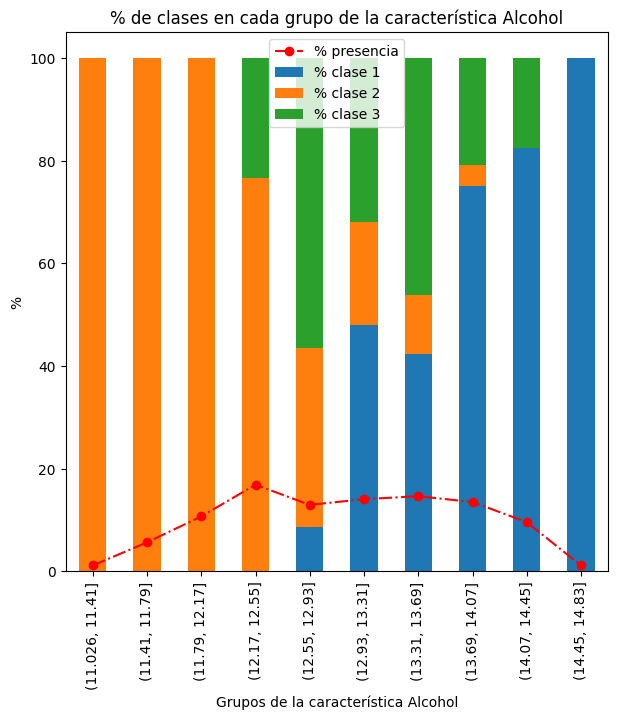

In [67]:
plot_num_feat(df_train_raw, 'Alcohol', bins=10)


#### Magnesium
---

La gráfica muestra cómo se distribuyen las clases de vino según distintos rangos de magnesio.  
En los valores más bajos de magnesio, los vinos pertenecen casi exclusivamente a la **clase 2**, indicando que esta clase se concentra en los rangos inferiores.

En niveles intermedios de magnesio aparece una mezcla de clases, con presencia significativa de **clase 1** y **clase 3**, lo que sugiere que estos rangos no permiten separar tan claramente las categorías.

En los rangos más altos de magnesio, los vinos vuelven a ser mayoritariamente de **clase 2**, aunque con menor presencia global en el dataset, como refleja la línea roja.

En general, el magnesio presenta cierta relación con el tipo de vino, pero no muestra un patrón de separación tan claro como otras características del conjunto de datos.

---


C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


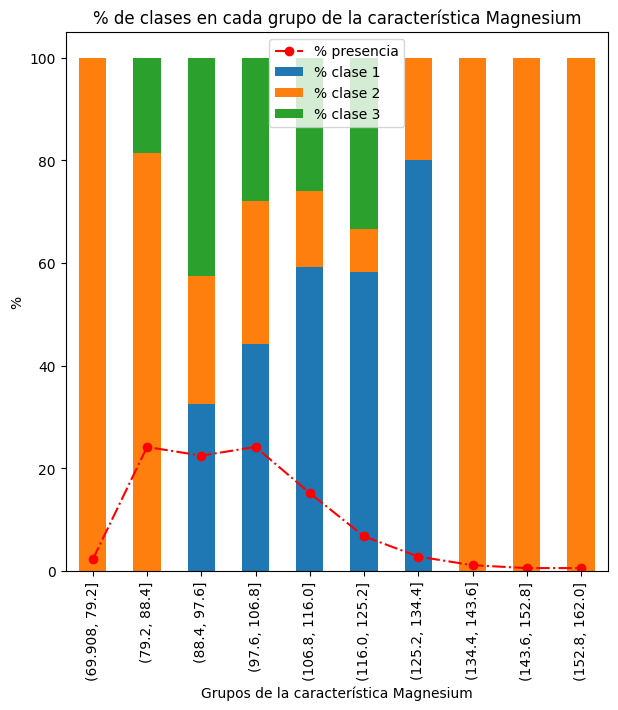

In [68]:
plot_num_feat(df_train_raw, 'Magnesium', 10)


#### Malicacid
---
La gráfica muestra una relación clara entre la acidez málica y las clases de vino.  
En los valores más bajos de Malicacid predominan casi por completo los vinos de **clase 2**, lo que indica que esta clase suele presentar menor acidez málica.

En los rangos intermedios aparece una mezcla de clases, con presencia relevante de clase 1 y clase 3, lo que sugiere que estos valores no separan tan claramente las categorías.

En los valores altos de Malicacid domina de forma muy marcada la **clase 3**, reflejando que esta clase corresponde a vinos con mayor acidez málica.

La línea roja muestra que la mayoría de vinos se concentran en los rangos centrales.

En conjunto, Malicacid presenta un patrón bastante claro para diferenciar clases, especialmente separando clase 2 (valores bajos) y clase 3 (valores altos).

---


C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


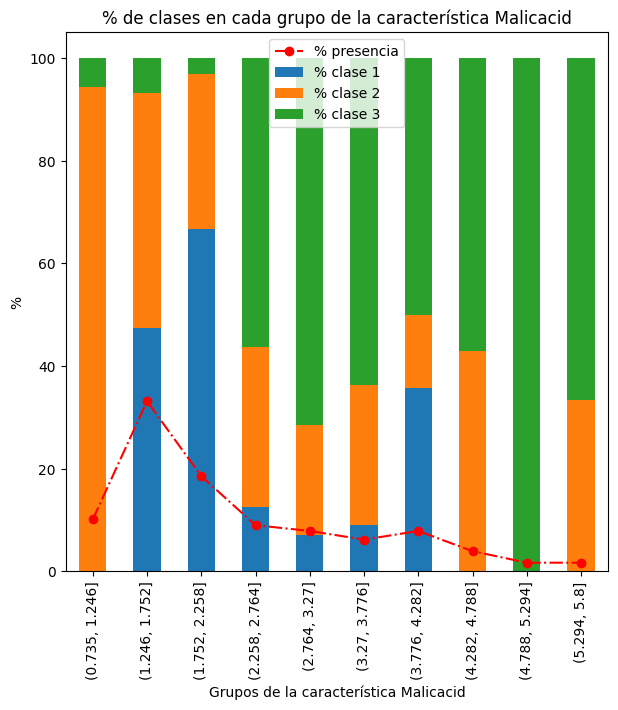

In [69]:
plot_num_feat(df_train_raw, 'Malicacid', 10)


#### Ash
---
La variable Ash muestra un comportamiento poco discriminativo entre clases.  
En los rangos bajos de Ash, los vinos pertenecen casi en su totalidad a la **clase 2**, sin presencia relevante del resto de clases.

A partir de valores medios, comienzan a aparecer vinos de **clase 1** y **clase 3**, pero en proporciones muy mezcladas y sin un patrón claro.  
En los rangos más altos, vuelve a predominar la mezcla, aunque con algo más de presencia de clase 1 y clase 3.

La línea roja indica que la mayoría de vinos se concentran en valores intermedios, donde precisamente menos diferenciación hay entre clases.

En conjunto, Ash no presenta una estructura clara que permita separar categorías, por lo que se considera una **característica débil** para la clasificación del vino.

---


C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


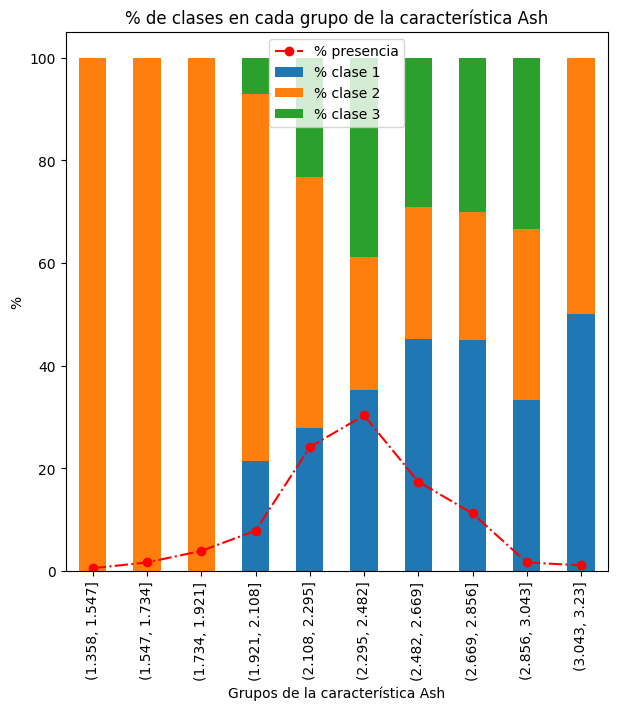

In [70]:
plot_num_feat(df_train_raw, 'Ash', 10)


#### Alcalinity_of_ash
---
Los rangos más bajos de alcalinidad están asociados principalmente a la **clase 1**, mientras que los valores más altos favorecen la **clase 2**.  
La **clase 3** aparece sobre todo en los rangos intermedios.

La presencia del dataset se concentra en valores medios.  
La variable aporta cierta separación entre clases, aunque de forma limitada.

---


C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


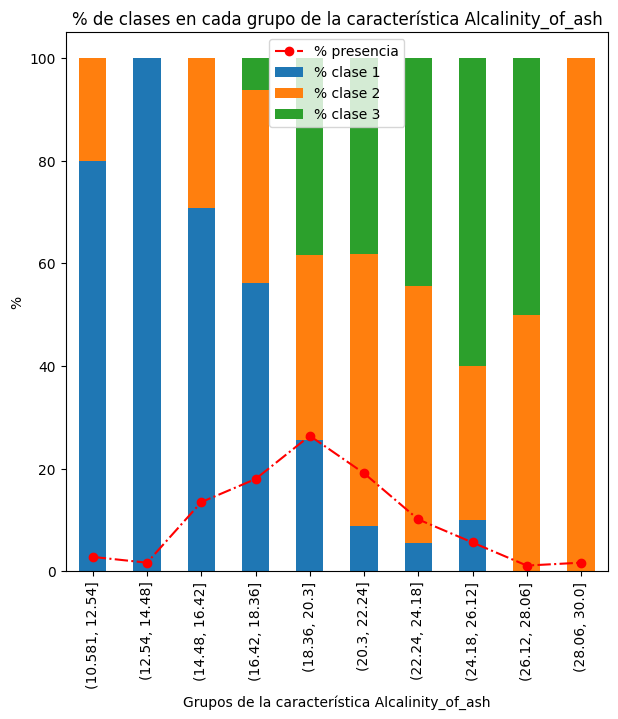

In [72]:
plot_num_feat(df_train_raw, 'Alcalinity_of_ash', 10)


#### Total_phenols
---
La variable Total_phenols muestra un patrón de separación muy claro entre las clases.  
En los valores más bajos predominan los vinos de **clase 3**, mientras que en los rangos bajos-medios empieza a aparecer la **clase 2** de forma relevante.

A partir de valores intermedios, la **clase 2** es la más presente, dominando la mayoría de esos rangos.  
En los valores altos, la **clase 1** pasa a ser claramente mayoritaria, mostrando que los vinos de esta clase tienen niveles superiores de fenoles totales.

La línea roja indica que el mayor volumen del dataset se encuentra en valores medios de Total_phenols.

En conjunto, esta característica es **altamente discriminativa**, separando de forma muy marcada la clase 1 (valores altos), la clase 2 (rangos medios) y la clase 3 (valores bajos).  
Es una de las variables más relevantes del dataset.

---


C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


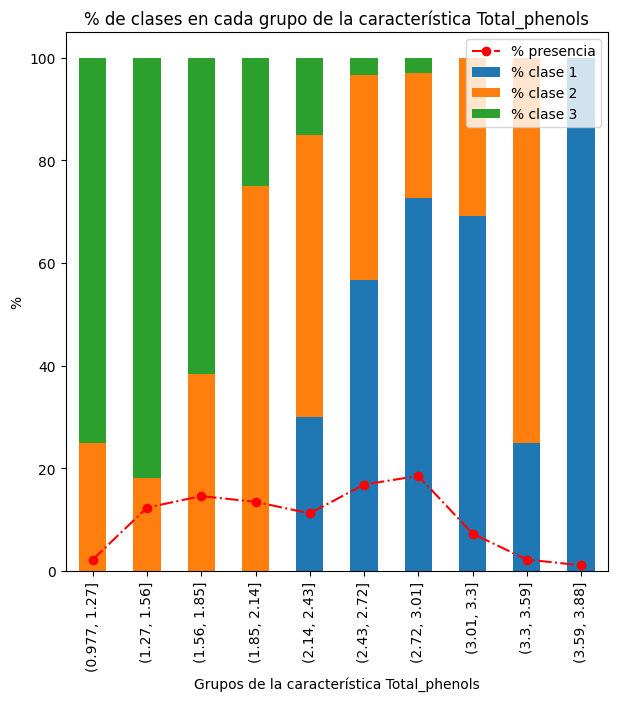

In [73]:
plot_num_feat(df_train_raw, 'Total_phenols', 10)


#### Flavanoids
---
La variable Flavanoids muestra uno de los patrones de separación más claros de todo el dataset.  
En los valores más bajos predominan casi por completo los vinos de **clase 3**, mientras que los rangos bajos-medios están dominados por la **clase 2**.

A partir de valores intermedios, comienza a aparecer la **clase 1**, que rápidamente pasa a ser la clase dominante conforme aumentan los flavonoides.  
En los valores altos, prácticamente todos los vinos pertenecen a la clase 1, mostrando una separación muy marcada.

La línea roja indica que la mayoría de vinos se sitúan en valores intermedios, donde las clases se distribuyen de manera más equilibrada.

En conjunto, Flavanoids es una **característica extremadamente discriminativa**, separando nítidamente las tres clases:  
- Clase 3 → valores bajos  
- Clase 2 → valores medios-bajos  
- Clase 1 → valores medios-altos y altos  

Es, sin duda, una de las variables más influyentes para la clasificación del vino.

---


C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


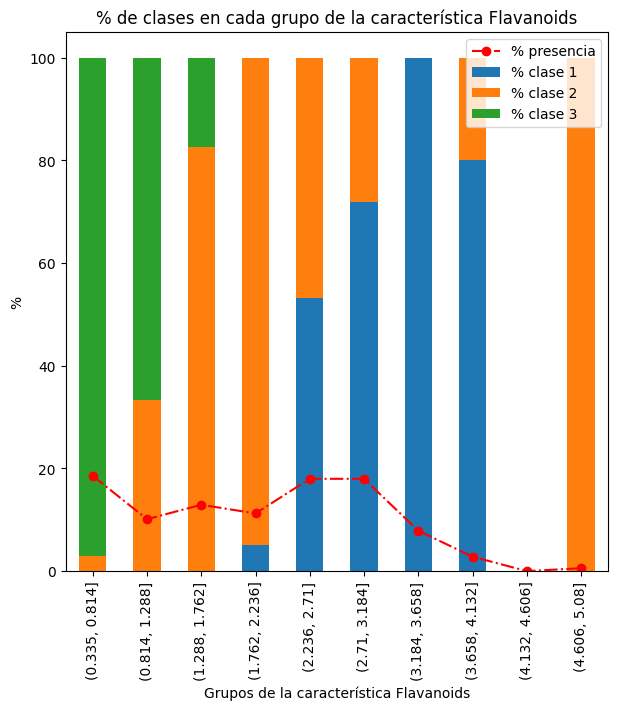

In [74]:
plot_num_feat(df_train_raw, 'Flavanoids', 10)

#### Nonflavanoid_phenols
---
La variable *Nonflavanoid_phenols* muestra un patrón de separación más moderado que otras características, pero aun así aporta información útil para distinguir clases.

En los valores más bajos predomina la **clase 2**, acompañada de una presencia relevante de la **clase 1**.  
A medida que los valores aumentan, la presencia de la clase 1 disminuye de forma notable, y la **clase 3** comienza a dominar los rangos medios-altos y altos.

En los grupos superiores, la **clase 3** llega a representar casi el 100% de los vinos, lo que indica que valores altos de esta característica están fuertemente asociados a dicha clase.

La línea roja de presencia muestra que la mayor parte del dataset se concentra en valores intermedios, donde hay mezcla de clases, aunque con tendencia creciente hacia la clase 3.

En resumen, aunque la separación no es tan marcada como en *Flavanoids* o *OD280/OD315*, esta variable sí ayuda a definir un patrón claro:
- Valores bajos → mezcla de clases 1 y 2  
- Valores medios → transición hacia clase 3  
- Valores altos → dominio casi absoluto de la clase 3  

Su utilidad es complementaria dentro del modelo de clasificación.

---



C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


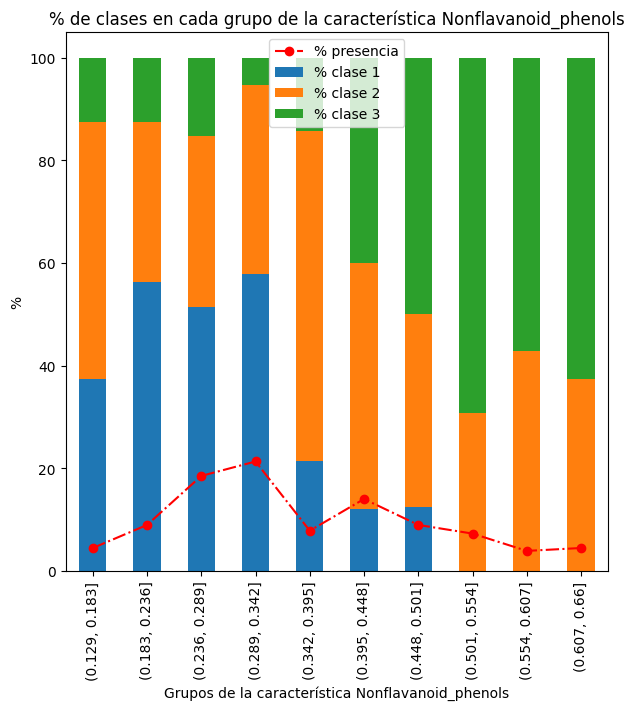

In [75]:
plot_num_feat(df_train_raw, 'Nonflavanoid_phenols', 10)

#### Proanthocyanins
---
La variable *Proanthocyanins* muestra una separación de clases bastante clara, especialmente en los valores medios y altos.

En los valores más bajos, la distribución está repartida principalmente entre **clase 2** y **clase 3**, con muy poca presencia de la clase 1.  
A partir de los rangos intermedios, comienza a aumentar de forma notable la **clase 1**, que llega a dominar completamente algunos intervalos.  
En los valores más altos, la **clase 2** vuelve a aparecer como la clase predominante, quedando la clase 1 más reducida y la clase 3 casi ausente.

La línea roja indica que la mayor presencia de datos se concentra en los grupos centrales, donde además se observa la transición entre clases (de clase 3 → clase 1 → clase 2).

En términos de capacidad discriminativa:
- Valores bajos → mezcla entre clase 2 y clase 3  
- Valores medios → dominio creciente de clase 1  
- Valores altos → dominio claro de clase 2  

Esto convierte a *Proanthocyanins* en una variable útil para separar clases, especialmente porque cada rango tiende a concentrar una clase distinta.

---


C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


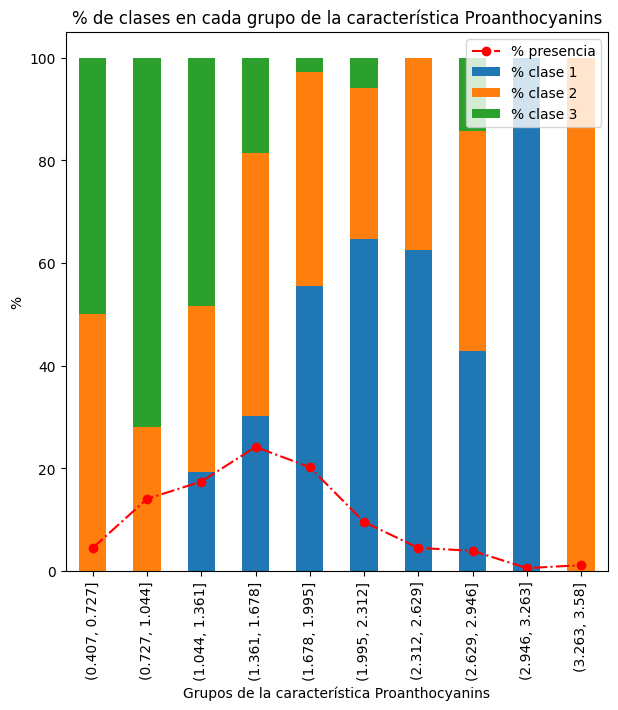

In [76]:
plot_num_feat(df_train_raw, 'Proanthocyanins', 10)


#### Color_intensity
---
La intensidad de color muestra un patrón muy claro de separación entre clases.  
En los rangos más bajos, la **clase 2** domina casi por completo, lo que indica que los vinos menos intensos suelen pertenecer a esta categoría.

En los valores intermedios aparece una mezcla entre **clase 1** y **clase 3**, con una transición visible:  
- Al inicio del rango medio predomina clase 1.  
- A medida que aumenta la intensidad, la clase 3 empieza a ganar fuerza.

En los valores más altos de la característica, la **clase 3** domina de forma absoluta: casi el 100 % de los vinos con color más intenso pertenecen a esta clase.

La línea roja (% de presencia) muestra que la mayor parte de los vinos se concentra en valores intermedios y ligeramente altos, lo que coincide con la zona donde se observa la transición entre clases.

En conjunto, *Color_intensity* es una variable muy discriminativa:  
- Baja intensidad → clase 2  
- Media → mezcla, con tendencia a clase 1 o 3 según el nivel  
- Alta intensidad → clase 3  

---


C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


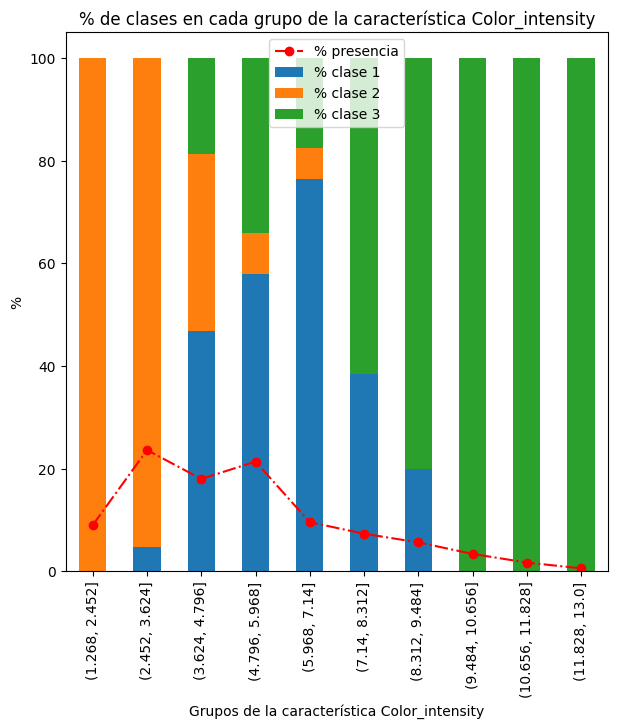

In [77]:
plot_num_feat(df_train_raw, 'Color_intensity', 10)

#### Hue
---
La característica *Hue* muestra un comportamiento bastante marcado según aumentan sus valores.

En los rangos más bajos, la **clase 3** domina por completo, lo que indica que los vinos con tonalidades más bajas tienden a pertenecer a este grupo.  
En rangos intermedios aparece una mezcla visible entre **clase 1** y **clase 2**, especialmente con un fuerte peso de la clase 2.

En los valores más altos del Hue, la **clase 2** pasa a dominar casi al 100 %, mostrando que los vinos con tonalidad más alta pertenecen mayoritariamente a esta categoría.

La línea roja (% de presencia) indica que la mayoría de datos se concentran en los rangos centrales, coincidiendo con la zona donde se mezclan las clases.

En resumen, Hue muestra un buen poder de separación:
- Hue bajo → clase 3  
- Hue medio → mezcla de clases, especialmente clase 2  
- Hue alto → clase 2  

---


C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


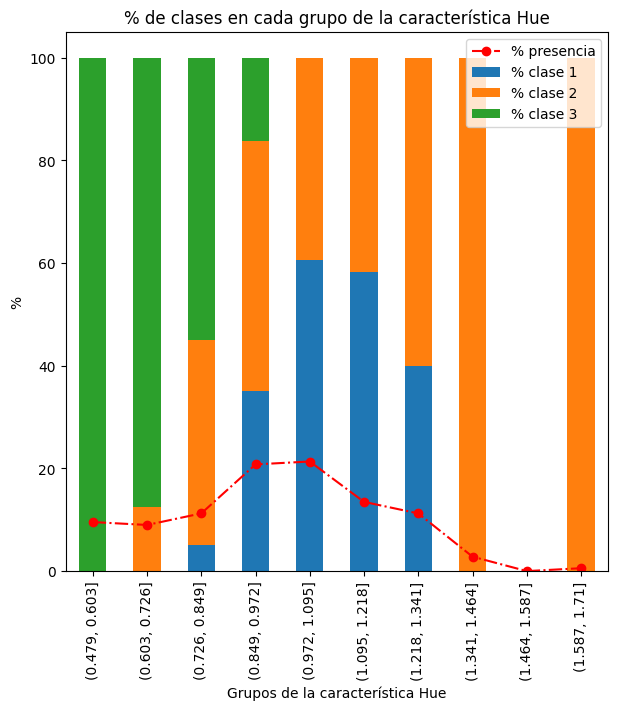

In [78]:
plot_num_feat(df_train_raw, 'Hue', 10)

#### OD280_OD315_of_diluted_wines
---
Esta característica muestra una separación muy clara entre clases y es una de las más discriminativas del dataset.

En los valores más bajos, domina totalmente la **clase 3**, lo que indica que los vinos con menor relación OD280/OD315 pertenecen casi exclusivamente a esta clase.

En valores intermedios aparece una transición donde predomina la **clase 2**, con pequeñas proporciones de clase 1.  
Finalmente, en los rangos más altos, la **clase 1** domina de forma casi absoluta, mostrando una separación muy marcada.

La línea roja indica que la mayor parte del dataset se distribuye en los valores medios y altos, coincidiendo con la zona donde aparecen clase 1 y 2.

En resumen, esta variable separa extremadamente bien las clases:
- Valores bajos → clase 3  
- Valores medios → clase 2  
- Valores altos → clase 1  
---


C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


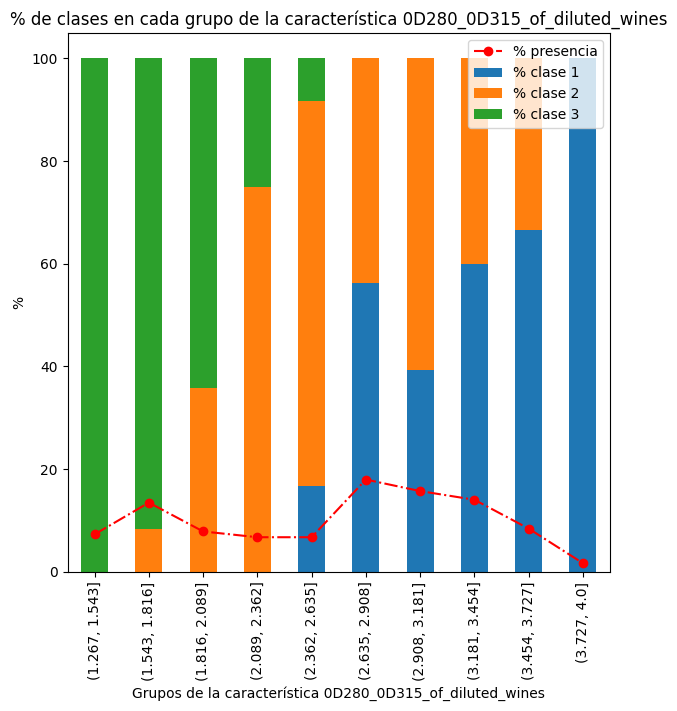

In [81]:
plot_num_feat(df_train_raw, '0D280_0D315_of_diluted_wines', 10)

#### Proline
---
La característica **Proline** es, probablemente, la más discriminativa de todo el dataset.

En los valores bajos, domina casi por completo la **clase 2**, lo que indica que los vinos con menor concentración de prolina pertenecen principalmente a esta categoría.

A partir de valores intermedios aparece la **clase 3**, aunque con menor presencia que en otras variables.  
Sin embargo, a medida que Proline aumenta, la **clase 1 pasa a dominar de forma total**, llegando a ser prácticamente el 100% en los rangos altos.

La línea roja muestra que la mayor densidad de muestras está en valores medios y altos, lo que coincide con la zona donde la clase 1 es mayoritaria.

En resumen, es una variable extremadamente potente para clasificar:
- Valores bajos → clase 2  
- Valores intermedios → mezcla con clase 3  
- Valores altos → clase 1 (dominancia absoluta)

Su capacidad para separar clases es muy alta, incluso mejor que otras características como *Flavanoids* u *OD280/OD315*.  

---


C:\Users\balle\AppData\Local\Temp\ipykernel_27312\619188866.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned.groupby('bins')['target']


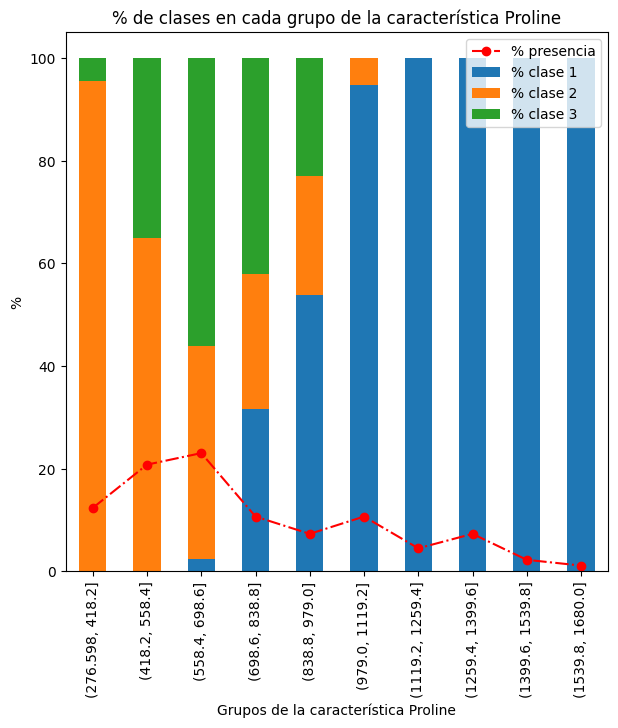

In [82]:
plot_num_feat(df_train_raw, 'Proline', 10)